In [1]:
import torch
from torch import nn, optim
import tqdm
import os
import tifffile as tiff
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms
import random
import matplotlib.pyplot as plt

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
set_seed(42)

# Custom Dataset class for 3 channel/image
class ImageDataset(Dataset):
    def __init__(self, image_dir,size):
        self.image_dir = image_dir
        #self.transform = transform
        self.image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.tiff')]
        #we don't need to resize into 96*96 because we are doing that in below contrastive transform (self.resize_transform = transforms.resize((96,96)))
        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomResizedCrop(size=size),
            transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.GaussianBlur(kernel_size=9),
        ])
    
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")
        
        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0
        
        # Convert to a torch tensor
        image = torch.tensor(image, dtype=torch.float32)
        
        if self.transform:
            image1 = self.transform(image)
            image2 = self.transform(image)
        return image1, image2

In [4]:
# 1 channel
class ImageDataset(Dataset):
    def __init__(self, image_dir, size, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.tiff')]
        self.resize_transform = transforms.Resize((size,size))
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")
        
        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0
        
        # Calculate sharpness for each layer
        sharpness_scores = []
        for i in range(3):
            layer = image[i]
            gy, gx = np.gradient(layer)
            gnorm = np.sqrt(gx**2 + gy**2)
            sharpness = np.average(gnorm)
            sharpness_scores.append(sharpness)
        

        # Find the index of the sharpest layer
        sharpest_layer_index = np.argmax(sharpness_scores)
        
        # Determine the anchor (sharpest layer) and the other two layers (augmentations)
        anchor = image[sharpest_layer_index]
        other_indices = [i for i in range(3) if i != sharpest_layer_index]
        augmentation1 = image[other_indices[0]]
        augmentation2 = image[other_indices[1]]

        # Convert to a torch tensor and add channel dimension
        anchor = torch.tensor(anchor, dtype=torch.float32).unsqueeze(0)
        img1 = torch.tensor(augmentation1, dtype=torch.float32).unsqueeze(0)
        img2 = torch.tensor(augmentation2, dtype=torch.float32).unsqueeze(0)
        
        # Apply resize transform
        #anchor = self.resize_transform(anchor)
        img1 = self.resize_transform(img1)
        img2 = self.resize_transform(img2)
        
        return img1, img2

In [5]:
def plot_curves(train_losses, val_losses, train_top1_accs, val_top1_accs, train_top5_accs, val_top5_accs, train_mean_pos, val_mean_pos):
    epochs = range(1, len(train_losses) + 1)

    # Plot loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Top-1 accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_top1_accs, 'bo-', label='Training Top-1 Accuracy')
    plt.plot(epochs, val_top1_accs, 'ro-', label='Validation Top-1 Accuracy')
    plt.title('Training and Validation Top-1 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Top-1 Accuracy (%)')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

    # Plot Top-5 accuracy
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, train_top5_accs, 'bo-', label='Training Top-5 Accuracy')
    plt.plot(epochs, val_top5_accs, 'ro-', label='Validation Top-5 Accuracy')
    plt.title('Training and Validation Top-5 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Top-5 Accuracy (%)')
    plt.legend()

    # Plot Mean Position of Positive Example
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, train_mean_pos, 'bo-', label='Training Mean Position')
    plt.plot(epochs, val_mean_pos, 'ro-', label='Validation Mean Position')
    plt.title('Training and Validation Mean Position of Positive Example')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Position')
    plt.legend()

    plt.tight_layout()
    plt.show()



# Function to split dataset with explicit percentage
def split_dataset(dataset, val_percentage):
    val_size = int(len(dataset) * val_percentage)
    train_size = len(dataset) - val_size
    return random_split(dataset, [train_size, val_size])


In [6]:
# 1 channel
class Resnet(nn.Module):
    def __init__(self, hidden_dim):
        super(Resnet, self).__init__()
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify the first convolutional layer to accept single-channel images
        self.convnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, hidden_dim)  # Output layer with hidden_dim output
        )

    def forward(self, x):
        return self.convnet(x)

# 1 channel

class Resnet(nn.Module):
    def __init__(self, hidden_dim):
        super(Resnet, self).__init__()
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify the first convolutional layer to accept single-channel images
        self.convnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, hidden_dim)  # Output layer with hidden_dim output
        )

    def forward(self, x):
        # Forward pass through the ResNet layers
        x = self.convnet.conv1(x)
        x = self.convnet.bn1(x)
        x = self.convnet.relu(x)
        x = self.convnet.maxpool(x)
        print(f"Shape after conv1: {x.shape}")

        x = self.convnet.layer1(x)
        print(f"Shape after layer1: {x.shape}")

        x = self.convnet.layer2(x)
        print(f"Shape after layer2: {x.shape}")

        x = self.convnet.layer3(x)
        print(f"Shape after layer3: {x.shape}")

        x = self.convnet.layer4(x)
        print(f"Shape after layer4: {x.shape}")

        # Global average pooling
        x = self.convnet.avgpool(x)
        print(f"Shape after avgpool: {x.shape}")

        # Flatten the tensor
        x = torch.flatten(x, 1)
        print(f"Shape after flatten: {x.shape}")

        # Pass through the projection head
        x = self.convnet.fc(x)
        print(f"Shape after projection head: {x.shape}")

        return x


# Model for 3 channel/image
class Resnet(nn.Module):
    def __init__(self, hidden_dim):
        super(Resnet, self).__init__()
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')

        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, hidden_dim)  # Output layer with hidden_dim output
        )

    def forward(self, x):
        # Pass through the convolutional layers
        x = self.convnet.conv1(x)
        x = self.convnet.bn1(x)
        x = self.convnet.relu(x)
        x = self.convnet.maxpool(x)

        x = self.convnet.layer1(x)
        x = self.convnet.layer2(x)
        x = self.convnet.layer3(x)
        x = self.convnet.layer4(x)

        # Print the shape after each layer
        print(f"Shape after conv1: {x.shape}")
        print(f"Shape after layer1: {x.shape}")
        print(f"Shape after layer2: {x.shape}")
        print(f"Shape after layer3: {x.shape}")
        print(f"Shape after layer4: {x.shape}")

        # Global average pooling
        x = self.convnet.avgpool(x)
        x = torch.flatten(x, 1)
        print(f"Shape after avgpool: {x.shape}")

        # Pass through the projection head
        x = self.convnet.fc(x)
        print(f"Shape after projection head: {x.shape}")

        return x


class Resnet(nn.Module):
    def __init__(self, hidden_dim):
        super(Resnet, self).__init__()
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')

        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, hidden_dim)  # Output layer with hidden_dim output
        )

    def forward(self, x):
        return self.convnet(x)
    

#print(Resnet(96))

In [7]:
def SimCLR_loss(feats, temperature):
    # Calculate cosine similarity
    cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
    
    # Mask out cosine similarity to itself
    self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
    cos_sim.masked_fill_(self_mask, -9e15)
    
    # Find positive example -> batch_size//2 away from the original example
    pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
    
    # InfoNCE loss
    cos_sim = cos_sim / temperature
    nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
    nll = nll.mean()

    # Accuracy calculations
    comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # First position positive example
                          cos_sim.masked_fill(pos_mask, -9e15)],
                         dim=-1)
    sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)

    # Calculate accuracy metrics
    acc_top1 = (sim_argsort == 0).float().mean()
    acc_top5 = (sim_argsort < 5).float().mean()
    mean_pos = 1 + sim_argsort.float().mean()

    return nll, acc_top1.item(), acc_top5.item(), mean_pos.item()

In [8]:
def train(train_loader, model, epochs, lr=5e-4, temperature=0.07, weight_decay=1e-4, device='cuda', validate=False):
    if not validate:
        model = model.train().to(device)
    else:
        model = model.eval().to(device)
    
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=lr / 50)

    train_losses = []
    train_top1_accs = []
    train_top5_accs = []
    mean_positions = []

    for epoch in range(epochs):
        total_loss = 0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        for imgs1, imgs2 in train_loader:
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)
            imgs = torch.cat((imgs1, imgs2), dim=0)
            feats = model(imgs)

            # Compute the loss and accuracy
            loss, acc_top1, acc_top5, mean_pos = SimCLR_loss(feats, temperature)

            if not validate:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                lr_scheduler.step()

            total_loss += loss.item()
            total_top1_acc += acc_top1
            total_top5_acc += acc_top5
            total_mean_pos += mean_pos

        avg_loss = total_loss / len(train_loader)
        avg_top1_acc = total_top1_acc / len(train_loader)
        avg_top5_acc = total_top5_acc / len(train_loader)
        avg_mean_pos = total_mean_pos / len(train_loader)

        train_losses.append(avg_loss)
        train_top1_accs.append(avg_top1_acc)
        train_top5_accs.append(avg_top5_acc)
        mean_positions.append(avg_mean_pos)

        print(f"Epoch {epoch + 1}/{epochs} | "
              f"Loss: {avg_loss:.4f} | "
              f"Top-1 Acc: {avg_top1_acc:.2f}% | "
              f"Top-5 Acc: {avg_top5_acc:.2f}% | "
              f"Mean Position: {avg_mean_pos:.2f}")

    return model, (train_losses, train_top1_accs, train_top5_accs, mean_positions)


Batch 0:
  Image1: torch.Size([16, 1, 96, 96])
  Image2: torch.Size([16, 1, 96, 96])
training
Epoch 1/1 | Loss: 0.0115 | Top-1 Acc: 1.00% | Top-5 Acc: 1.00% | Mean Position: 1.00
validating
Epoch 1/1 | Loss: 0.7823 | Top-1 Acc: 1.00% | Top-5 Acc: 1.00% | Mean Position: 1.00


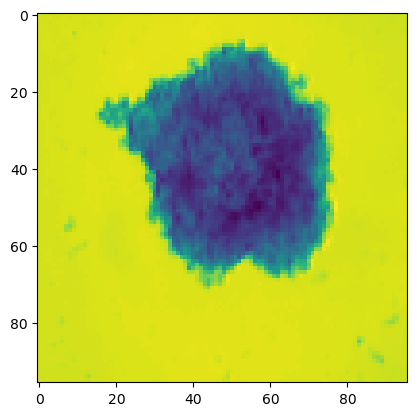

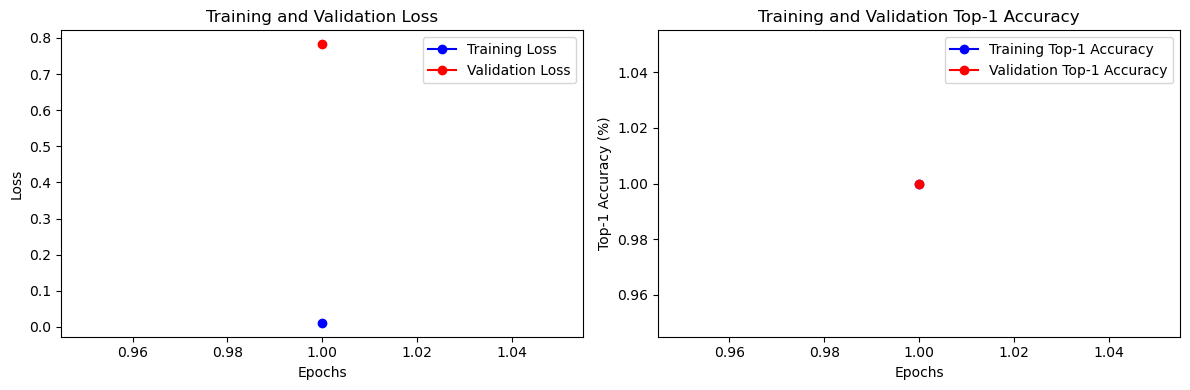

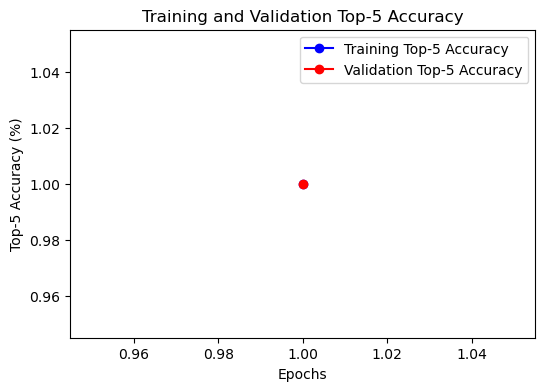

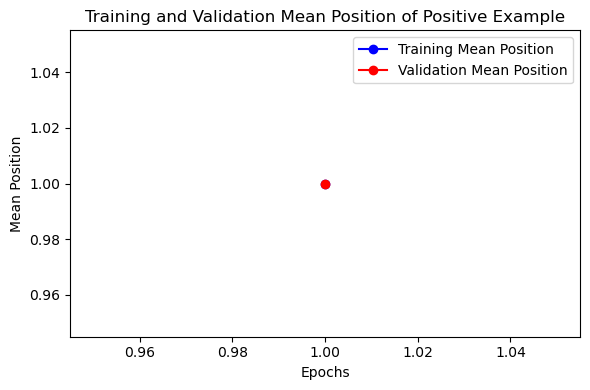

In [9]:
batch_size = 16
size = 96

image_dir = r"../../tiff_experiment_unsupervised_data/combined"
dataset = ImageDataset(image_dir=image_dir,size=size)


# Split the dataset with 20% for validation
val_percentage = 0.2
train_dataset, val_dataset = split_dataset(dataset, val_percentage)

# Define DataLoaders
train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          drop_last=False, 
                          pin_memory=True, 
                          num_workers=0) #num_workers=os.cpu count() using cluster gpu
val_loader = DataLoader(val_dataset, 
                        batch_size=batch_size, 
                        shuffle=False, 
                        drop_last=False, 
                        pin_memory=True, 
                        num_workers=0)

for i, (image1, image2) in enumerate(train_loader):
    print(f"Batch {i}:")
    print(f"  Image1: {image1.shape}")
    print(f"  Image2: {image2.shape}")
    plt.imshow(image1[0,0])
    break

model = Resnet(size)
#print(model)
print('training')
model, train_results = train(train_loader, model, epochs=1, device='cuda')
print('validating')
model, val_results = train(val_loader, model, epochs=1, device='cuda', validate=True)

train_losses, train_top1_accs, train_top5_accs, train_mean_pos = train_results
val_losses, val_top1_accs, val_top5_accs, val_mean_pos = val_results

plot_curves(train_losses, val_losses, train_top1_accs, val_top1_accs, train_top5_accs, val_top5_accs, train_mean_pos, val_mean_pos)